# **Project: Multitask Learning for Geometric Shape Classification and Counting**

## 1. Overview

In this project, you will design, implement, and evaluate a **multitask neural network** that performs **two tasks simultaneously**:

1. **Classification** – identify which pair of geometric shape types appears in a 28×28 binary image (135 possible configurations).
2. **Regression** – predict how many shapes of each type are present (6 regression targets).

This project focuses on **multi-task learning**, i.e., using one shared model to learn several related tasks at once. You will compare how adding an auxiliary task affects performance and training dynamics.

---

## 2. Dataset

You will use the **Geometric Shape Numbers (GSN)** dataset:

```bash
!wget https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip
```

This will create a directory `data/` containing:

* **10,000 images** (28×28x1, grayscale)
* **labels.csv** – counts of each of six shape types per image

Each image contains exactly **two types** of geometric figures (out of six) and **10 shapes total**.

**Shape classes:**

| Index | Shape type     |
| ----: | -------------- |
|     0 | square         |
|     1 | circle         |
|     2 | triangle up    |
|     3 | triangle right |
|     4 | triangle down  |
|     5 | triangle left  |

Example row from `labels.csv`:

```
name,squares,circles,up,right,down,left
img_00000.png,0,0,0,4,0,6
```

Here, the image contains **4 right-pointing triangles** and **6 left-pointing triangles**.

**Split:**

* Training: first 9,000 samples
* Validation: last 1,000 samples

Examples:
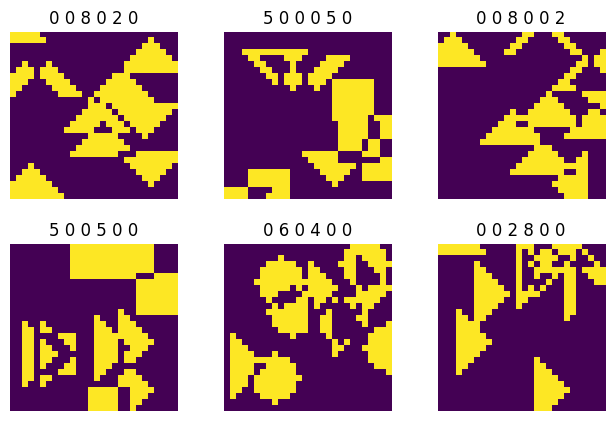

---

## 3. Tasks and objectives

You must design a **multitask deep learning system** that:

1. **Classifies** each image into one of **135 possible configurations**, representing:

   * which **two shape classes** appear, and
   * how their counts (1–9) sum to 10.

   → Example: "3 circles + 7 squares" is one configuration class.

2. **Regresses** the number of shapes of each type (a 6-dimensional real-valued output).

3. Combines both objectives in a **joint loss** function (Hint: losses are implemented in PyTorch):


$$ Loss = \text{NLLLoss(classification)} + \lambda_{\text{cnt}} \cdot \text{SmoothL1Loss(regression)}
$$

---

## 4. Model requirements

### Architecture constraints

You must use **exactly this feature extractor (backbone)**:

```python
nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(64 * 28 * 28, 256), nn.ReLU()
)
```

Then add **two separate heads**:

* `head_cls`: outputs log-probabilities for 135 classes
* `head_cnt`: outputs 6 regression values (counts)

The model must return two outputs: `(log_probs, counts)`.

You may add dropout or batch normalization inside the heads, **but you must not modify the backbone**.

---

## 5. Training setup

* Optimizer: **Adam**, learning rate = 1e-3
* Epochs: up to **100** (use **early stopping**)
* Batch sizes: **64** (train), **1000** (validation)
* Device: GPU allowed for Notebook, but your **final code must run on GPU within ~30 minutes**
* Random seed: set `torch.manual_seed(1)` for reproducibility
* Split: **exactly 9,000 train / 1,000 validation**


---

## 6. Data preprocessing and augmentation

You must implement a **PyTorch `Dataset` class** that:

* Reads `labels.csv`
* Loads the corresponding image (from `data/`)
* Returns both:
  * the image (as a tensor)
  * the labels (counts for 6 shapes)
* Optionally applies transformations

### Required augmentations

You must implement **at least three** of the following:

1. Random horizontal flip
2. Random vertical flip
3. Random 90° rotation (must correctly rotate orientation labels: up → right → down → left)
4. Random brightness/contrast (mild)
5. Gaussian noise
6. Random erasing (small areas only)


---

## 7. Evaluation metrics

Implement and report the following metrics on the validation set:

### (a) **Classification (135-way)**

* Top-1 accuracy
* Macro F1-score
* Per-pair accuracy (aggregate by unordered shape pair, e.g. {circle, up})

### (b) **Regression (6-D counts)**

* RMSE per class and overall
* MAE per class and overall

Also plot:

* Training and validation losses
* Validation accuracy and RMSE over epochs

**Important**: This task is not about finding the best architecture; we expect at least 50% accuracy, but achieving results higher than that will not affect the grade for the assignment**.


---

## 8. Experiments and analysis

You must train and compare **three model settings**:

| Setting | Description                                      |
| :------ | :----------------------------------------------- |
| 1       | **Classification-only:** λ_cnt = 0               |
| 2       | **Regression-only:** classification loss ignored |
| 3       | **Multitask:** λ_cnt = with your choose          |

For each experiment:

* Train until early stopping
* Record loss, accuracy, RMSE, and runtime
* Compare results and explain how λ influences learning
* Discuss whether multitask learning improves the main tasks


---

## 9. Final deliverables

You must submit .zip project with:

1. **Code** (`.ipynb` or `.py`) that:

   * Downloads and extracts the dataset
   * Defines dataset, dataloaders, model, loss, training loop, evaluation, and plotting
   * Can run start-to-end without interaction, and finishes within 30 minutes on Colab T4 GPUs
   * Includes three experiment configurations

2. **Report (2–4 pages, PDF)** including:
   * Section on (EDA) Exploratory Data Analysis in your report: no more than 3 graphs or tables describing the data set.
   * Model architecture
   * Description and justification of augmentations
   * Results table (loss, accuracy, RMSE for all runs)
   * Learning curves
   * Discussion on multitask effects

3. **README.md**:

   * Link to Colab version of task for fast replication.
   * Approximate runtime and resource requirements

---

## 10. Grading rubric

Component	Description	Points
1. Implementation correctness	Correct use of the fixed backbone, two-headed model, and proper training loop (classification + regression).	30%
2. Data & augmentations	Proper dataset loading, preprocessing, and at least three augmentations with brief justification.	20%
3. Evaluation & experiments	Correct computation of metrics (accuracy, F1, RMSE) and completion of all three λ configurations (λ=0, regression-only, your choice λ).	30%
4. Report & analysis
A clear separation of concerns (e.g. headers in notebooks, modules in code) and concise 2–4 page report with results tables, learning curves, confusion matrix, and short discussion on multitask effects and error examples.
20%

###### Readability and modularity will be considered within each grading component. Clear structure (headers in notebooks, docstrings, modular code) significantly improves evaluation speed. Emphasize using clear headers to help reviewers navigate efficiently.
---

In [3]:
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-13 15:53:24--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-13 15:53:25--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.05s   

2025-11-13 15:53:25 (106 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



# Calculating labels for classification problem

There are 135 combinations. This comes from:
$$\binom{6}{2}\cdot 9 = 15\cdot9 = 135$$

We propose the following labeling: <br>
For counting label $$[a_0, a_1, a_2, a_3, a_4, a_5]$$ with the only non-zero elements $a_i$ and $a_j$, where $i<j$ we will use a label equal to:
$$ f(i, j)\cdot9+a_i-1$$
Where $f(g, h)$, where $g<h$, is a simple indexing function: <br>
$$f(g,h) = \binom{h}{2}+g$$ where $0\leq g<h\leq5$. This provides us with unique labels from $0$ to $134$

In [4]:
import math as mth

def cnt_to_cls_idx(cnt_label):
  a_1, i_1, i_2 = 0, 0, 0
  for i, cnt in enumerate(cnt_label):
    if cnt > 0:
      if not a_1:
        a_1 = cnt
        i_1 = i
      else:
        i_2 = i
        break
  cls_idx = (mth.comb(i_2, 2)+i_1)*9+a_1-1
  return cls_idx

def cls_idx_to_cnt(cls_idx):
    if not (0 <= cls_idx <= 134):
        raise ValueError("cls_idx must be in [0, 134] for 6 labels and counts 1..9")

    a_1 = (cls_idx % 9) + 1
    pair_idx = cls_idx // 9
    i_2 = 1
    while mth.comb(i_2 + 1, 2) <= pair_idx:
        i_2 += 1
    i_1 = pair_idx - mth.comb(i_2, 2)

    cnt_label = [0]*6
    cnt_label[i_1] = a_1
    cnt_label[i_2] = 10 - a_1
    return cnt_label


# Test the labeling and create O(1) mapping
labels = set()
for a1 in range(1, 10):
  for idx1 in range(6):
    for idx2 in range(idx1+1, 6):
      label_cnt = [0]*6
      label_cnt[idx1] = a1
      label_cnt[idx2] = 10-a1
      label = cnt_to_cls_idx(label_cnt)
      if label in labels:
        print(f"Not ok {label}")
      if cls_idx_to_cnt(label) != label_cnt:
        print("Not ok")
      labels.add(label)

if len(labels) == 135:
  print("Ok")



Ok


## Adding new labels

In [5]:
import pandas as pd
import numpy as np

CSV_PATH = "./data/labels.csv"
df = pd.read_csv(CSV_PATH)

label_cols = df.columns[1:]
n_images = len(df)

class_indices = []
for i in range(n_images):
    cnt_label = df[label_cols].iloc[i].values
    class_idx = cnt_to_cls_idx(cnt_label)
    class_indices.append(class_idx)

df["class_idx"] = class_indices


## Exploring the Data


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


cnt_label_cols = df.columns[1:7]
n_images = len(df)


# --- COUNT LABELS ANALYSIS ---
total_shapes     = df[cnt_label_cols].sum().sum()
shape_totals     = df[cnt_label_cols].sum()
shape_percentage = 100 * shape_totals / total_shapes

corr = df[cnt_label_cols].corr(numeric_only=True)
nonzero_means = df[cnt_label_cols].replace(0, np.nan).mean()
presence_percentage = 100 * (df[cnt_label_cols] > 0).sum() / n_images

# Per-image constraints
nonzero_per_image = (df[cnt_label_cols] > 0).sum(axis=1)
sum_per_image     = df[cnt_label_cols].sum(axis=1)

prop_exact_two_nonzero = (nonzero_per_image == 2).mean() * 100
prop_sum_eq_10         = (sum_per_image == 10).mean() * 100
prop_both_constraints  = ((nonzero_per_image == 2) & (sum_per_image == 10)).mean() * 100

# --- CLASS INDEX ANALYSIS (robust) ---
n_classes = 135

# counts for all classes [0..n_classes-1], missing -> 0
class_counts_raw = df["class_idx"].value_counts()          # counts only for seen classes
class_counts_full = class_counts_raw.reindex(range(n_classes), fill_value=0)

# summary table: count + % of images containing that class
class_presence_pct = 100 * class_counts_full / n_images
class_summary = pd.DataFrame({
    "class_id": range(n_classes),
    "count": class_counts_full.values,
    "pct_of_images": class_presence_pct.values
})

# stats
num_used_classes = int((class_counts_full > 0).sum())
pct_classes_used = 100 * num_used_classes / n_classes
unused_classes = class_summary.loc[class_summary["count"] == 0, "class_id"].tolist()

# top / bottom 10 (including unseen)
top10_classes = class_summary.sort_values("count", ascending=False).head(10)
least10_present = (
    class_summary[class_summary["count"] > 0]
    .sort_values(["count", "class_id"], ascending=[True, True])
    .head(10)
    .reset_index(drop=True)
)
# --- PRINT SUMMARY ---
print("=== DATA OVERVIEW ===")
print(f"Images: {n_images}")
print(f"Count label columns: {list(label_cols)}")
print(f"Number of classes: {n_classes}")

print("\n=== COUNT LABELS SUMMARY ===")
print(f"Total sum of all counts: {int(total_shapes)}")
print("\nPer-label totals:")
print(shape_totals)
print("\nPer-label percentage of total (%):")
print(shape_percentage.round(2))
print("\nPresence percentage per label (%% of images with >0):")
print(presence_percentage.round(2))
print("\nMean of non-zero values per label:")
print(nonzero_means.round(3))

print("\n=== CONSTRAINT CHECKS ===")
print(f"Images with exactly 2 non-zero count labels: {prop_exact_two_nonzero:.2f}%")
print(f"Images with sum(counts) == 10: {prop_sum_eq_10:.2f}%")
print(f"Images satisfying both: {prop_both_constraints:.2f}%")

print("\nCorrelation matrix between count labels:")
print(corr.round(3))

print(f"Classes used: {num_used_classes}/{n_classes} ({pct_classes_used:.2f}%)")
print("Top 10 classes (id, count, % of images):")
print(top10_classes[["class_id", "count", "pct_of_images"]].to_string(index=False))

print("\nLeast 10 classes (id, count, % of images):")
print(least10_present[["class_id", "count", "pct_of_images"]].to_string(index=False))
print("Unused common classes:")
print(unused_classes)


=== DATA OVERVIEW ===
Images: 10000
Count label columns: ['squares', 'circles', 'up', 'right', 'down', 'left']
Number of classes: 135

=== COUNT LABELS SUMMARY ===
Total sum of all counts: 100000

Per-label totals:
squares    16574
circles    17149
up         16530
right      16770
down       16857
left       16120
dtype: int64

Per-label percentage of total (%):
squares    16.57
circles    17.15
up         16.53
right      16.77
down       16.86
left       16.12
dtype: float64

Presence percentage per label (%% of images with >0):
squares    32.79
circles    34.10
up         33.19
right      33.54
down       33.67
left       32.71
dtype: float64

Mean of non-zero values per label:
squares    5.055
circles    5.029
up         4.980
right      5.000
down       5.007
left       4.928
dtype: float64

=== CONSTRAINT CHECKS ===
Images with exactly 2 non-zero count labels: 100.00%
Images with sum(counts) == 10: 100.00%
Images satisfying both: 100.00%

Correlation matrix between count labels:

## Conclusions
The dataset is well balanced: all shapes appear with similar frequency, there are no strong correlations between shape types, and whenever a shape is present its average count is close to 5 out of 10. Based on this, not much data augmentation is needed.

## Dataset Class
Each transform is applied independently with a fixed probability.

In [42]:
import pandas as pd
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1)


class MultitaskDataset(Dataset):

  def __init__(self, root: str, transforms = None, transform_prob: float = 0.3):
    self.root = Path(root)
    self.df = pd.read_csv(root)
    if transforms is None:
      transforms = []
    self.transforms = transforms
    self.transform_prob = transform_prob

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_path = self.root.parent / self.df.iloc[idx, 0]
    image = Image.open(img_path).convert('L')
    label_cnt = self.df.iloc[idx, 1:].tolist()



    for transform in self.transforms:
      if torch.rand(1) < self.transform_prob:
        image, label_cnt = transform(image, label_cnt)


    cls_idx = cnt_to_cls_idx(label_cnt)
    image = TF.to_tensor(image)
    return image, torch.tensor(label_cnt, dtype=torch.float32), cls_idx


def horizontal_flip(image, labels_cnt):
  labels_cnt[3], labels_cnt[5] = labels_cnt[5], labels_cnt[3]
  return image.transpose(Image.FLIP_LEFT_RIGHT), labels_cnt


def vertical_flip(image, labels_cnt):
  labels_cnt[2], labels_cnt[4] = labels_cnt[4], labels_cnt[2]
  return image.transpose(Image.FLIP_TOP_BOTTOM), labels_cnt

def rotation(image, labels_cnt):
  labels_cnt = [labels_cnt[0], labels_cnt[1], labels_cnt[3], labels_cnt[4], labels_cnt[5], labels_cnt[2]]
  return image.rotate(90), labels_cnt

def gaussian_noise(image, labels_cnt):
  image = TF.to_tensor(image)
  noise = torch.randn_like(image) * 0.002
  image = image + noise
  image = TF.to_pil_image(image)
  return image, labels_cnt

def erode_tensor(x, kernel_size=3):
    pad = kernel_size // 2
    return -F.max_pool2d(-x, kernel_size, stride=1, padding=pad)

def random_erasing(image, labels_cnt):
    image = TF.to_tensor(image)

    # musi być (N, C, H, W)
    x = image.unsqueeze(0)
    x = erode_tensor(x, kernel_size=3)
    image = x.squeeze(0)

    return TF.to_pil_image(image), labels_cnt


## Test Transforms


No transform


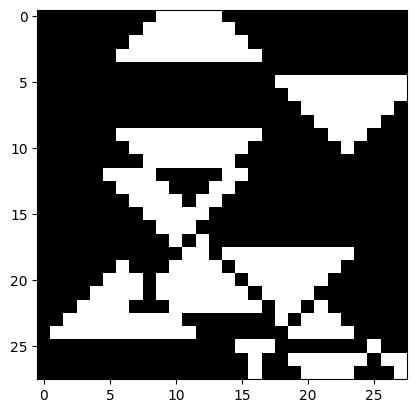

Horizontal flip


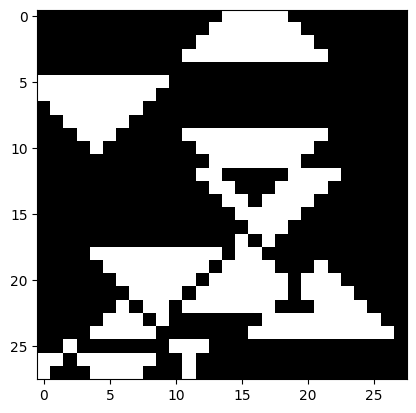

Vertical flip


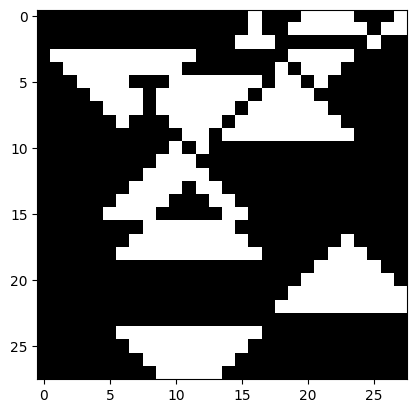

Rotation


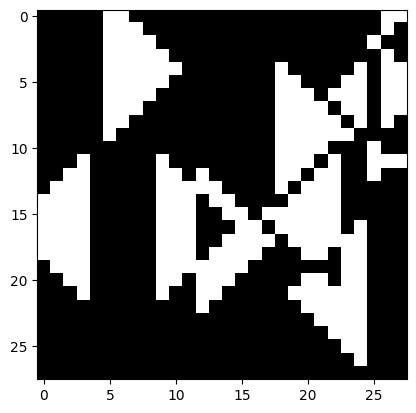

Gaussian noise


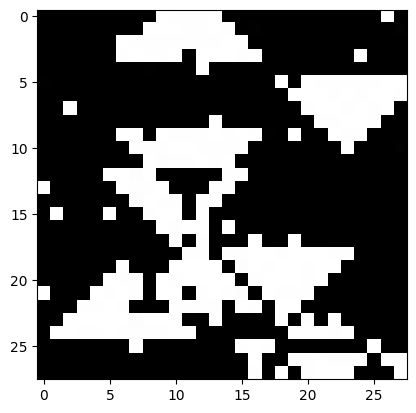

Random erasing


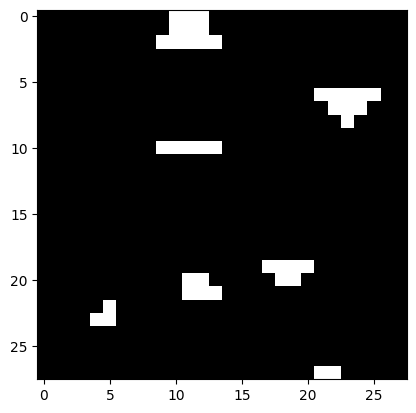

In [43]:
from IPython.utils.path import random
img = Image.open(Path("./data/labels.csv").parent / df.iloc[0, 0]).convert('L')
print("No transform")
plt.imshow(img, cmap='gray')
plt.show()
print("Horizontal flip")
plt.imshow(horizontal_flip(img, df.iloc[0, 1:].tolist())[0], cmap='gray')
plt.show()
print("Vertical flip")
plt.imshow(vertical_flip(img, df.iloc[0, 1:].tolist())[0], cmap='gray')
plt.show()
print("Rotation")
plt.imshow(rotation(img, df.iloc[0, 1:].tolist())[0], cmap='gray')
plt.show()
print("Gaussian noise")
plt.imshow(gaussian_noise(img, df.iloc[0, 1:].tolist())[0], cmap='gray')
plt.show()
print("Random erasing")
plt.imshow(random_erasing(img, df.iloc[0, 1:].tolist())[0], cmap='gray')
plt.show()

## Splitting the data

In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
import pandas as pd
import os

g = torch.Generator().manual_seed(1)

train_base = MultitaskDataset(
    root="./data/labels.csv",
    transforms=[horizontal_flip, vertical_flip, rotation],
    transform_prob=0.3
)

test_base = MultitaskDataset(
    root="./data/labels.csv",
    transforms=[],
)

n = len(train_base)
split = int(0.9 * n)

train_idx = [i for i in range(split)]
test_idx  = [i for i in range(split,n)]

assert (len(train_idx), len(test_idx)) == (9000, 1000)

train_ds = Subset(train_base, train_idx)
test_ds  = Subset(test_base,  test_idx)

num_workers = min(4, os.cpu_count() // 2)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=1000, shuffle=False, num_workers=num_workers, pin_memory=True)


## Network structure


In [ ]:
import torch.nn as nn


class MultiTaskNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(64 * 28 * 28, 256), nn.ReLU()
        )
        self.head_cls = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 135)
        )
        self.head_cnt = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 6)
        )

    def forward(self, x):
        feat = self.backbone(x)
        logits = self.head_cls(feat)
        log_probs = F.log_softmax(logits, dim=1)
        counts = self.head_cnt(feat)
        return log_probs, counts


## Training


## Visualiser

In [ ]:
# import torch
# import torch.nn as nn

# class TrainingVisualizer:
#     def __init__(self, lr):
#         self.lr = lr
#         self.first_linear_layer = None

#     def attach(self, model: nn.Module):
#         """Znajdź pierwszą warstwę liniową w modelu i zapamiętaj referencję."""
#         self.first_linear_layer = None
#         for m in model.modules():
#             if isinstance(m, nn.Linear):
#                 self.first_linear_layer = m
#                 break

#     def plot_gradients_and_loss(self, batch_idx: int, loss: float):
#         layer = self.first_linear_layer
#         # Jeśli nie znaleziono warstwy lub brak gradientu – po prostu pomiń
#         if layer is None or layer.weight is None or layer.weight.grad is None:
#             return

#         # Zabezpieczenia przed dzieleniem przez zero / NaN
#         w_std = layer.weight.detach().std()
#         g_std = layer.weight.grad.detach().std()
#         if w_std == 0 or torch.isnan(w_std) or torch.isnan(g_std):
#             return

#         grad_to_weight_ratio = (self.lr * g_std / w_std).item()

#         # ...tu Twoje rysowanie / logowanie:
#         # self.writer.add_scalar("train/loss", loss, batch_idx)
#         # self.writer.add_scalar("train/grad_to_weight_ratio", grad_to_weight_ratio, batch_idx)


## Training

In [ ]:
def train_epoch(
    model: torch.nn.Module,
    device: torch.device,
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    log_interval: int,
    # visualizer: TrainingVisualizer,
    verbose: bool = False,
    lambda_cnt: float = 0.5
) -> float:
    model.train()
    total_loss = 0.0
    n_total = 0

    for batch_idx, (data, target_cnt, target_cls) in enumerate(train_loader):
        data = data.to(device)
        target_cls = target_cls.to(device).long()
        target_cnt = target_cnt.to(device).float()

        optimizer.zero_grad()

        log_probs, counts = model(data)

        loss_cls = F.nll_loss(log_probs, target_cls)
        loss_cnt = F.smooth_l1_loss(counts, target_cnt)

        loss = loss_cls + lambda_cnt * loss_cnt
        loss.backward()
        optimizer.step()

        batch_size = data.size(0)
        total_loss += loss.item() * batch_size
        n_total += batch_size

        if batch_idx % log_interval == 0:
            if verbose:
                done, total = batch_idx * batch_size, len(train_loader.dataset)
                print(
                    f"Train Epoch: {epoch} [{done}/{total} images ({done / total:.0%})]\t"
                    + f"Loss: {loss.item():.6f}"
                )

    avg_loss = total_loss / n_total
    return avg_loss


In [ ]:
def test(
    model: torch.nn.Module,
    device: torch.device,
    test_loader: torch.utils.data.DataLoader,
    epoch: int,
    lambda_cnt: float = 0.5,
    verbose: bool = False,
):
    model.eval()

    n_classes = 135
    n_reg_targets = 6

    total_loss_cls = 0.0
    total_loss_cnt = 0.0
    n_total = 0

    # classification metrics
    n_correct_cls = 0
    n_correct_pair = 0  # per-pair accuracy
    conf_mat = torch.zeros(n_classes, n_classes, dtype=torch.long)

    # regression metrics
    sum_sq_err_per_class = torch.zeros(n_reg_targets)
    sum_abs_err_per_class = torch.zeros(n_reg_targets)

    with torch.no_grad():
        for data, target_cnt, target_cls in test_loader:
            data = data.to(device)
            target_cls = target_cls.to(device).long()
            target_cnt = target_cnt.to(device).float()

            log_probs, counts = model(data)

            loss_cls = F.nll_loss(log_probs, target_cls, reduction="sum")
            loss_cnt = F.smooth_l1_loss(counts, target_cnt, reduction="sum")

            batch_size = data.size(0)
            total_loss_cls += loss_cls.item()
            total_loss_cnt += loss_cnt.item()
            n_total += batch_size

            pred_cls = log_probs.argmax(dim=1)

            n_correct_cls += (pred_cls == target_cls).sum().item()

            true_pair_idx = target_cls // 9
            pred_pair_idx = pred_cls // 9
            n_correct_pair += (true_pair_idx == pred_pair_idx).sum().item()

            for t, p in zip(target_cls.view(-1), pred_cls.view(-1)):
                conf_mat[t.item(), p.item()] += 1

            diff = counts - target_cnt          # (B, 6)
            sq_err = diff ** 2
            abs_err = diff.abs()

            sum_sq_err_per_class += sq_err.sum(dim=0).cpu()
            sum_abs_err_per_class += abs_err.sum(dim=0).cpu()

    # average losses
    avg_loss_cls = total_loss_cls / n_total
    avg_loss_cnt = total_loss_cnt / n_total
    avg_loss_total = avg_loss_cls + lambda_cnt * avg_loss_cnt

    # --- classification: top-1 & per-pair ---
    top1_acc = n_correct_cls / n_total
    pair_acc = n_correct_pair / n_total

    # --- macro F1 over 135 classes ---
    f1_per_class = []
    for c in range(n_classes):
        tp = conf_mat[c, c].item()
        fp = conf_mat[:, c].sum().item() - tp
        fn = conf_mat[c, :].sum().item() - tp

        if tp == 0 and fp == 0 and fn == 0:
            f1 = 0.0  # class never appears
        else:
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            if precision + recall == 0:
                f1 = 0.0
            else:
                f1 = 2 * precision * recall / (precision + recall)
        f1_per_class.append(f1)

    macro_f1 = sum(f1_per_class) / n_classes

    # --- regression: RMSE / MAE per class + overall ---
    num_samples = n_total
    rmse_per_class = (sum_sq_err_per_class / num_samples).sqrt()
    mae_per_class = sum_abs_err_per_class / num_samples

    num_elements = n_total * n_reg_targets
    rmse_overall = (sum_sq_err_per_class.sum() / num_elements) ** 0.5
    mae_overall = sum_abs_err_per_class.sum() / num_elements

    if verbose:
        print(f"\nTest set (epoch {epoch}):")
        print(f"  Classification (135-way):")
        print(f"    Top-1 accuracy: {100.0 * top1_acc:.2f}%")
        print(f"    Macro F1-score: {macro_f1:.4f}")
        print(f"    Per-pair accuracy (unordered pair): {100.0 * pair_acc:.2f}%")

        print(f"\n  Regression (6-D counts):")
        class_names = ["squares", "circles", "up", "right", "down", "left"]
        print("    RMSE per class:")
        for name, v in zip(class_names, rmse_per_class):
            print(f"      {name:7s}: {v:.4f}")
        print("    MAE per class:")
        for name, v in zip(class_names, mae_per_class):
            print(f"      {name:7s}: {v:.4f}")
        print(f"    RMSE overall: {rmse_overall:.4f}")
        print(f"    MAE overall: {mae_overall:.4f}")

        print(f"\n  Losses:")
        print(f"    cls={avg_loss_cls:.4f}, cnt={avg_loss_cnt:.4f}, total={avg_loss_total:.4f}\n")

    # return everything so we can log/plot
    return {
        "loss_cls": avg_loss_cls,
        "loss_cnt": avg_loss_cnt,
        "loss_total": avg_loss_total,
        "top1": top1_acc,
        "macro_f1": macro_f1,
        "pair_acc": pair_acc,
        "rmse_per_class": rmse_per_class,
        "mae_per_class": mae_per_class,
        "rmse_overall": rmse_overall.item(),
        "mae_overall": mae_overall.item(),
    }


# Hyperparameters

In [ ]:
epochs = 100
lambda_cnt = 1
lr = 0.001
log_interval = 10

train_losses = []
val_losses = []
val_top1 = []
val_rmse_overall = []



# Test

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

model = MultiTaskNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# visualizer = TrainingVisualizer(lr=optimizer.param_groups[0]["lr"])
# visualizer.attach(model)

for epoch in range(1, epochs+1):
    train_epoch(
        model,
        device,
        train_loader,
        optimizer,
        epoch,
        log_interval,
        # visualizer,
        verbose=True,
        lambda_cnt=lambda_cnt
    )
    metrics = test(
        model,
        device,
        test_loader,
        epoch,
        lambda_cnt=lambda_cnt,
        verbose=True,
    )

    train_losses.append(train_loss)
    val_losses.append(metrics["loss_total"])
    val_top1.append(metrics["top1"])
    val_rmse_overall.append(metrics["rmse_overall"])



In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

# 1) Training vs validation loss
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_losses, label="Train loss")
plt.plot(epochs_range, val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation losses")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Validation accuracy and RMSE
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, [100 * a for a in val_top1], label="Val top-1 acc (%)")
plt.plot(epochs_range, val_rmse_overall, label="Val RMSE (overall)")
plt.xlabel("Epoch")
plt.title("Validation accuracy and RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
